In [56]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support
from sklearn import preprocessing
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
import spacy
import string
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import utils

In [2]:
# https://spacy.io/docs/usage/models
nlp = spacy.load("en_core_web_md")

In [3]:
train = pd.read_csv('data/train.csv')
test  = pd.read_csv('data/test.csv')

In [4]:
train.head(2)

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL


In [5]:
test.head(2)

,id,text
0,id02310,"Still, as I urged our leaving Ireland with suc..."
1,id24541,"If a fire wanted fanning, it could readily be ..."


In [54]:
# http://www.nltk.org/book/ch02.html
nltk_stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours',
'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers',
'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into',
'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here',
'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so',
'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now']

In [72]:
STOPLIST = set(nltk_stopwords + ["n't", "'s", "'m", "ca"] + list(ENGLISH_STOP_WORDS))

SYMBOLS = " ".join(string.punctuation).split(" ") + ["-----", "---", "...", "“", "”", "'ve"]

def tokenizeText(sample):

    # get the tokens using spaCy
    tokens = nlp(sample)

    # lemmatize
    lemmas = []
    for tok in tokens:
        lemmas.append(tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_)
    tokens = lemmas

    # stoplist the tokens
    # tokens = [tok for tok in tokens if tok not in STOPLIST]

    # stoplist symbols
    tokens = [tok for tok in tokens if tok not in SYMBOLS]

    # remove large strings of whitespace
    while "" in tokens:
        tokens.remove("")
    while " " in tokens:
        tokens.remove(" ")
    while "\n" in tokens:
        tokens.remove("\n")
    while "\n\n" in tokens:
        tokens.remove("\n\n")

    return tokens

In [58]:
sample = train.head(1)['text'][0]

In [73]:
tokenizeText(sample)

['this',
 'process',
 'however',
 'afford',
 'me',
 'no',
 'means',
 'of',
 'ascertain',
 'the',
 'dimension',
 'of',
 'my',
 'dungeon',
 'as',
 'i',
 'may',
 'make',
 'its',
 'circuit',
 'and',
 'return',
 'to',
 'the',
 'point',
 'whence',
 'i',
 'set',
 'out',
 'without',
 'be',
 'aware',
 'of',
 'the',
 'fact',
 'so',
 'perfectly',
 'uniform',
 'seem',
 'the',
 'wall']

In [29]:
print("Number of labelled training examples: {}".format(train.shape[0]))

Number of labelled training examples: 19579


Distribution of training data for the three authors


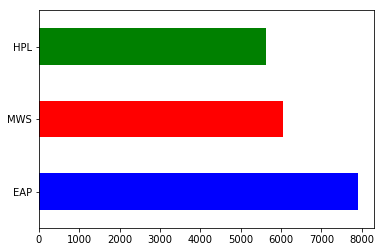

In [30]:
print("Distribution of training data for the three authors")
train['author'].value_counts().plot(kind="barh", color='brg')

In [31]:
print("Number of unlabelled test examples: {}".format(test.shape[0]))

Number of unlabelled test examples: 8392


In [32]:
# simple split for screening model performance
X_train, X_test, y_train, y_test = train_test_split(train.text, train.author, test_size=0.20, random_state=42)

In [33]:
# n-fold stratified CV for robust model performance
X = train.text
y = train.author

In [34]:
le = preprocessing.LabelEncoder()
le.fit(y)

LabelEncoder()

In [35]:
le.classes_

array(['EAP', 'HPL', 'MWS'], dtype=object)

In [ ]:
# sanity check for label ordering
# 0: EAP, 1: HPL, 2: MWS

In [36]:
y[:5]

0    EAP
1    HPL
2    EAP
3    MWS
4    HPL
Name: author, dtype: object

In [37]:
le.transform(y)[:5]

array([0, 1, 0, 2, 1])

In [38]:
def kfold_CV(clf, X, y, folds, transform=True):
    """ Run a stratified k-fold Cross Validation on the training set and print the results.
        
        Args:
            clf (Pipeline): sklearn Pipeline
            X    (pandas df): data points, here: novel snippets
            y    (pandas df): class labels, here: authors
            folds      (int): number of folds
            transform (bool): if True, use .fit_transform(); if False, use .fit()
    """

    kf = StratifiedKFold(n_splits=folds, shuffle=True)
    
    precision, recall, f1 = [], [], []

    fold_cntr = 1
    for train_index, test_index in kf.split(X,y):
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        if transform == True:
            clf.fit_transform(X_train, y_train)
        else:
            clf.fit(X_train, y_train)
        
        predicted = text_clf.predict(X_test)
        prec_, rec_, f1_ = precision_recall_fscore_support(y_test, predicted, average='macro')[:3]
        
        precision.append(prec_)
        recall.append(rec_)
        f1.append(f1_)
        
        print("FOLD: {} Precision: {}, Recall: {}, F1: {}".format(fold_cntr, round(prec_,3), round(rec_,3), round(f1_,3)))
        fold_cntr += 1
        
    print("\nAverage results of {}-fold stratified CV\n".format(folds))
    print("Precision: {}".format(np.mean(precision)))
    print("Recall:    {}".format(np.mean(recall)))
    print("Macro f1:  {}".format(np.mean(f1)))
        

## Multinomial Naive Bayes

In [74]:
text_clf = Pipeline([('vect', CountVectorizer(tokenizer=tokenizeText)),
                     ('clf', MultinomialNB(alpha=0.05)),
])

In [75]:
text_clf.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function tokenizeText at 0x1aaef29d8>, vocabulary=None)), ('clf', MultinomialNB(alpha=0.05, class_prior=None, fit_prior=True))])

In [76]:
text_clf.score(X_test, y_test)

0.83605720122574056

In [77]:
predicted = text_clf.predict(X_test)

In [78]:
print(classification_report(predicted, y_test))

             precision    recall  f1-score   support

        EAP       0.81      0.86      0.83      1469
        HPL       0.84      0.83      0.84      1083
        MWS       0.87      0.81      0.84      1364

avg / total       0.84      0.84      0.84      3916



In [79]:
kfold_CV(clf=text_clf, X=X, y=y, folds=10, transform=False)

FOLD: 1 Precision: 0.856, Recall: 0.859, F1: 0.857
FOLD: 2 Precision: 0.831, Recall: 0.834, F1: 0.832
FOLD: 3 Precision: 0.852, Recall: 0.856, F1: 0.853
FOLD: 4 Precision: 0.834, Recall: 0.836, F1: 0.834
FOLD: 5 Precision: 0.835, Recall: 0.839, F1: 0.836
FOLD: 6 Precision: 0.845, Recall: 0.849, F1: 0.846
FOLD: 7 Precision: 0.856, Recall: 0.86, F1: 0.857
FOLD: 8 Precision: 0.854, Recall: 0.858, F1: 0.855
FOLD: 9 Precision: 0.84, Recall: 0.841, F1: 0.841
FOLD: 10 Precision: 0.851, Recall: 0.851, F1: 0.85

Average results of 10-fold stratified CV

Precision: 0.8453698709260064
Recall:    0.8482562332086235
Macro f1:  0.8462804690851018


In [80]:
name = "naive_bayes_spacy_tokeniser"

In [81]:
utils.predict_for_kaggle(clf=text_clf, X=test.text, columns=le.classes_, ids=test.id, name=name)

,EAP,HPL,MWS
id,,,
id02310,1.900075e-05,4.800536e-06,9.999762e-01
id24541,1.000000e+00,4.871609e-08,2.298218e-11
id00134,1.374318e-02,9.862568e-01,2.465973e-08
id27757,1.238646e-01,8.761354e-01,3.865434e-13
id04081,9.711225e-01,1.829142e-02,1.058613e-02
id27337,4.757240e-01,5.242754e-01,5.731451e-07
id24265,4.986457e-01,4.927780e-01,8.576264e-03
id25917,2.757610e-04,2.046920e-04,9.995195e-01
id04951,9.999997e-01,2.891954e-07,2.563721e-16


## Logistic Regression

In [ ]:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('clf', LogisticRegression(C=1.0, penalty='l2', class_weight='balanced')),
])

In [ ]:
text_clf.fit(X_train, y_train)

In [ ]:
text_clf.score(X_test, y_test)

In [ ]:
predicted = text_clf.predict(X_test)

In [ ]:
print(classification_report(predicted, y_test))

In [ ]:
kfold_CV(clf=text_clf, X=X, y=y, folds=10)

## Support Vector Machine

In [ ]:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('clf', SGDClassifier()),
])

In [ ]:
text_clf.fit(X_train, y_train)

In [ ]:
text_clf.score(X_test, y_test)

In [ ]:
predicted = text_clf.predict(X_test)

In [ ]:
print(classification_report(predicted, y_test))

In [ ]:
kfold_CV(clf=text_clf, X=X, y=y, folds=10)